# Train Models Notebook

This notebook trains the different models that will be compared using the data from the ISIC 2017 challenge. The models that will be trained are:

- Unet (Baseline)
- Attention Unet
- R2Unet
- Attention R2Unet
- TransUnet

In [ ]:
# !pip install torch==2.3.0 torchaudio==2.3.0 torchvision==0.18.0
# !pip install albumentations numpy pandas scikit_learn kaggle
# !pip install resnest geffnet opencv-python pretrainedmodels tqdm Pillow packaging

In [ ]:
# pip install -i https://test.pypi.org/simple/ melanoma-segmentation==0.8

In [35]:
from configs.config_setting import CONFIG
from models.unet import UNet
from models.attention_unet import AttUNet
from models.trans_unet import TransUNet
from results.plots import plot_img_mask_pred
from utils.preparation_tools import prepare_datasets

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [36]:

base_dir = CONFIG["base_dir"]
image_folder = CONFIG["image_folder"]
gt_folder = CONFIG["gt_folder"]
model_name = CONFIG["model_name"]
split_train = CONFIG["split_train"]
split_val = CONFIG["split_val"]
split_test = CONFIG["split_test"]
image_size = 128
batch_size = CONFIG["batch_size"]
model_path = CONFIG["model_path"]
device = CONFIG["device"]

CONFIG_FINAL = CONFIG

In [37]:
# from google.colab import drive, files
# drive.mount('/content/drive')

CONFIG_DRIVE = CONFIG.copy()

CONFIG_DRIVE["image_folder"] = image_folder
CONFIG_DRIVE["gt_folder"] = gt_folder
CONFIG_DRIVE["model_name"] = model_name
CONFIG_DRIVE["split_train"] = split_train
CONFIG_DRIVE["split_val"] = split_val
CONFIG_DRIVE["split_test"] = split_test
CONFIG_DRIVE['image_size'] = image_size
CONFIG_DRIVE["batch_size"] = batch_size
CONFIG_DRIVE["model_path"] = model_path
CONFIG_DRIVE["device"] = device
CONFIG_FINAL = CONFIG_DRIVE

In [38]:
# Recieve the image and ground truth paths change
train_dataset, val_dataset, test_dataset = prepare_datasets(CONFIG_FINAL, train_transform_type="train")

# Get the train test and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Retrieving image and ground truth paths...


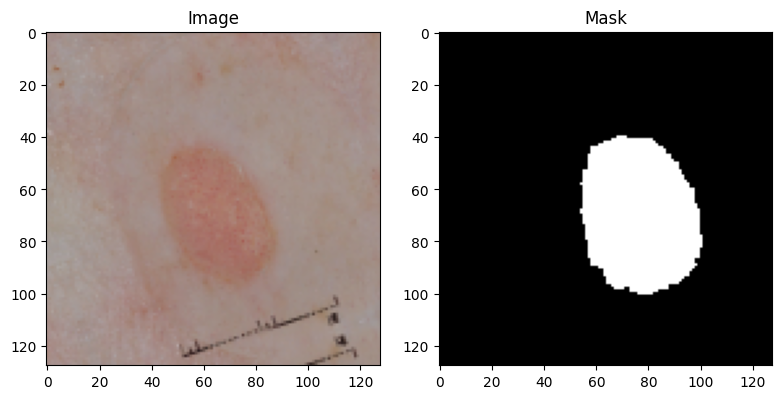

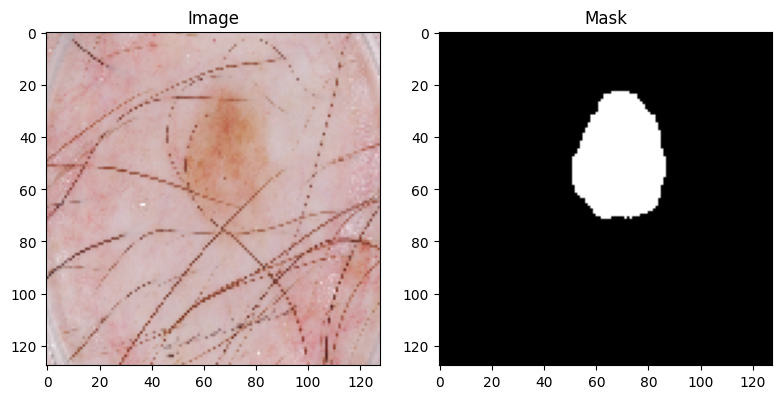

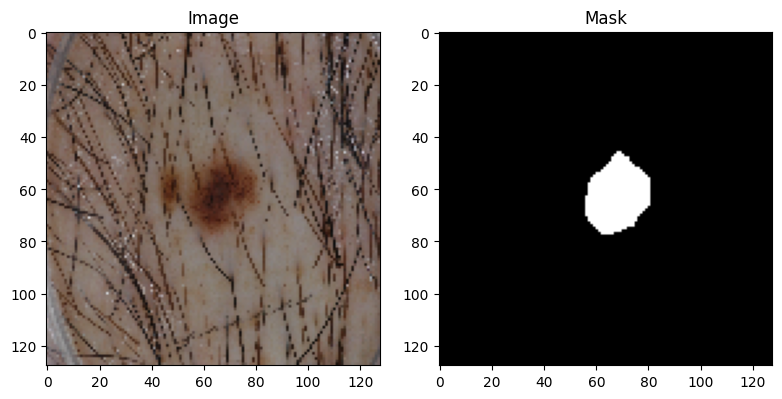

In [39]:
plot_img_mask_pred(train_dataset)
plot_img_mask_pred(val_dataset)
plot_img_mask_pred(test_dataset)


# Train Model

In [40]:
!nvidia-smi

Sun Oct 20 16:12:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:2B:00.0  On |                  N/A |
| 23%   37C    P8             10W /   75W |    1639MiB /   4096MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [42]:
model = AttUNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() >= 1:
    print("Using", torch.cuda.device_count(), "GPUs.")
    model = torch.nn.DataParallel(model)
    model.cuda()
# Check if the model is on the GPU



In [45]:
# Print amount of images in each dataset

print(f"Train dataset: {len(train_dataset)} images")
print(f"Val dataset: {len(val_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")

Train dataset: 1620 images
Val dataset: 180 images
Test dataset: 200 images


In [44]:
import torch.optim as optim
import torch.nn as nn
import time

# Define Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Define early stopping parameters
patience = 3  # Number of epochs to wait for improvement
min_delta = 1e-4  # Minimum improvement in the loss to be considered
best_loss = float('inf')
counter = 0  # Count epochs with no improvement
max_epochs = 10  # Maximum number of epochs to run

# Track the start time for timed stopping (if needed)
start_time = time.time()

# Train the model
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for i, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device).float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if i % 10 == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch {epoch} - Average Loss: {avg_loss}")

    # Check for early stopping based on loss improvement
    if avg_loss < best_loss - min_delta:
        best_loss = avg_loss
        counter = 0  # Reset counter if there's improvement
        print(f"Loss improved to {best_loss}, resetting patience counter.")
    else:
        counter += 1
        print(f"No improvement in loss. Patience counter: {counter}/{patience}")

    # If patience is exceeded, stop training
    if counter >= patience:
        print(f"Stopping early after {epoch} epochs due to lack of improvement.")
        break

# Save the model
torch.save(model.state_dict(), "attunet_512_aug.pth")
# files.download("attunet_512_aug.pth")

Epoch: 0, Batch: 0, Loss: 0.576777458190918
Epoch: 0, Batch: 10, Loss: 0.452572762966156
Epoch: 0, Batch: 20, Loss: 0.42362406849861145


KeyboardInterrupt: 

In [ ]:
model

In [ ]:
img_example = test_dataset[100]

result = model(img_example[0].unsqueeze(0).to(device))
print(result)
#Change every pixel to 1 if > 0 ans < 0
result = (result > 0).float()
print(result)

plt.imshow(result.squeeze().cpu().detach().numpy())
plt.show()

plt.imshow(img_example[1].squeeze().cpu().detach().numpy())
plt.show()